In [20]:
import pandas as pd
import numpy as np
import math
import requests
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
import time, os
from pandas.io.html import read_html

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import datetime
from datetime import datetime as dt
import seaborn as sns

import pickle

import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, lars_path
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

from math import sqrt

import scipy.stats as stats

In [21]:
#----------------------------------------------
# Continuation from project_2_webscraping
#----------------------------------------------

# Load pickled leages_df as new_leagues_df

with open('leagues_df.pickle','rb') as read_file:
    new_leagues_df = pickle.load(read_file)

In [22]:
new_leagues_df.head()

,POSITION,CLUB,SQUAD,AVG_AGE,FOREIGNERS,TOTAL_MARKET_VALUE (m€),AVG_MARKET_VALUE (m€),YEAR,P,W,...,RC,SHOTS_OT_PG,DRIBBLES_PG,FOULED_PG,SHOTS_PG_DEF,TACKLES_PG,INTERCEPTIONS_PG,FOULS_PG,OFFSIDES_PG,COUNTRY
0,1,Chelsea FC,33.0,25.5,24,443.90,13.45,2009,38,27,...,5,7.6,8.6,12.3,9.8,20.3,18.6,12.4,2.5,England
1,2,Manchester United,33.0,25.0,22,362.95,11.00,2009,38,27,...,4,5.8,8.7,11.7,10.9,21.8,15.8,11.7,2.2,England
2,3,Arsenal FC,45.0,21.7,31,281.00,6.24,2009,38,23,...,1,6.1,11.9,14.0,10.1,21.5,22.1,12.4,2.4,England
3,4,Tottenham Hotspur,41.0,23.3,20,249.20,6.08,2009,38,21,...,1,5.9,9.0,13.2,13.7,22.2,21.2,12.2,3.1,England
4,5,Manchester City,40.0,24.1,24,314.90,7.87,2009,38,18,...,2,5.1,7.7,12.8,13.5,21.1,21.2,11.9,3.2,England


In [23]:
# Create a list of columns to keep.  These are the numeric columns.

subset=['TOTAL_MARKET_VALUE (m€)', 'AVG_MARKET_VALUE (m€)', 'P', 'W',
       'D', 'L', 'GF', 'GA', 'GD', 'SHOTS_PG', 'POSSESSION_PERCENT',
       'PASS_PERCENT', 'AERIALS_WON', 'YC', 'RC', 'SHOTS_OT_PG', 'DRIBBLES_PG',
       'FOULED_PG', 'SHOTS_PG_DEF', 'TACKLES_PG', 'INTERCEPTIONS_PG',
       'FOULS_PG', 'OFFSIDES_PG', 'POINTS']

new_leagues_df1 = new_leagues_df[subset]
new_leagues_df1.head()

,TOTAL_MARKET_VALUE (m€),AVG_MARKET_VALUE (m€),P,W,D,L,GF,GA,GD,SHOTS_PG,...,RC,SHOTS_OT_PG,DRIBBLES_PG,FOULED_PG,SHOTS_PG_DEF,TACKLES_PG,INTERCEPTIONS_PG,FOULS_PG,OFFSIDES_PG,POINTS
0,443.90,13.45,38,27,5,6,103,32,71,21.9,...,5,7.6,8.6,12.3,9.8,20.3,18.6,12.4,2.5,86
1,362.95,11.00,38,27,4,7,86,28,58,18.3,...,4,5.8,8.7,11.7,10.9,21.8,15.8,11.7,2.2,85
2,281.00,6.24,38,23,6,9,83,41,42,17.4,...,1,6.1,11.9,14.0,10.1,21.5,22.1,12.4,2.4,75
3,249.20,6.08,38,21,7,10,67,41,26,17.9,...,1,5.9,9.0,13.2,13.7,22.2,21.2,12.2,3.1,70
4,314.90,7.87,38,18,13,7,73,45,28,13.8,...,2,5.1,7.7,12.8,13.5,21.1,21.2,11.9,3.2,67


In [24]:
# build correlations
new_leagues_df1.corr()

,TOTAL_MARKET_VALUE (m€),AVG_MARKET_VALUE (m€),P,W,D,L,GF,GA,GD,SHOTS_PG,...,RC,SHOTS_OT_PG,DRIBBLES_PG,FOULED_PG,SHOTS_PG_DEF,TACKLES_PG,INTERCEPTIONS_PG,FOULS_PG,OFFSIDES_PG,POINTS
TOTAL_MARKET_VALUE (m€),1.000000,0.963564,0.043317,0.666571,-0.265595,-0.565613,0.674345,-0.459361,0.668020,0.555740,...,-0.192228,0.622653,0.410024,-0.250563,-0.460850,-0.299410,-0.354045,-0.451897,0.008931,0.654807
AVG_MARKET_VALUE (m€),0.963564,1.000000,0.019587,0.656732,-0.267810,-0.562366,0.669403,-0.458931,0.664574,0.524267,...,-0.204718,0.609940,0.405022,-0.240347,-0.475816,-0.314622,-0.348600,-0.440360,0.004340,0.644215
P,0.043317,0.019587,1.000000,0.116378,0.202790,0.128561,0.088231,0.119010,-0.000986,-0.013749,...,0.213990,-0.087667,-0.290146,-0.136851,-0.011016,-0.055403,0.033737,-0.124442,0.009645,0.157291
W,0.666571,0.656732,0.116378,1.000000,-0.378824,-0.840478,0.885462,-0.724453,0.937008,0.676957,...,-0.160589,0.781367,0.356280,-0.038336,-0.598316,-0.042563,-0.105906,-0.277879,0.192701,0.986095
D,-0.265595,-0.267810,0.202790,-0.378824,1.000000,-0.063177,-0.305449,-0.004462,-0.197703,-0.241892,...,0.073390,-0.305113,-0.255783,0.085554,0.101789,0.036222,0.067753,0.140176,-0.021604,-0.221759
L,-0.565613,-0.562366,0.128561,-0.840478,-0.063177,1.000000,-0.766191,0.837398,-0.914686,-0.610997,...,0.213554,-0.717330,-0.354686,-0.055599,0.593266,0.006151,0.090702,0.180454,-0.194998,-0.896866
GF,0.674345,0.669403,0.088231,0.885462,-0.305449,-0.766191,1.000000,-0.508029,0.905167,0.740190,...,-0.170359,0.866298,0.413406,-0.041255,-0.504373,-0.070298,-0.132925,-0.310579,0.199024,0.878582
GA,-0.459361,-0.458931,0.119010,-0.724453,-0.004462,0.837398,-0.508029,1.000000,-0.825969,-0.445431,...,0.188915,-0.508766,-0.246226,-0.054104,0.629532,-0.024545,0.060656,0.102054,-0.170625,-0.763889
GD,0.668020,0.664574,-0.000986,0.937008,-0.197703,-0.914686,0.905167,-0.825969,1.000000,0.704239,...,-0.204720,0.818027,0.392067,-0.000301,-0.640757,-0.033895,-0.116927,-0.253624,0.214454,0.951966
SHOTS_PG,0.555740,0.524267,-0.013749,0.676957,-0.241892,-0.610997,0.740190,-0.445431,0.704239,1.000000,...,-0.135304,0.899682,0.365681,0.018429,-0.446873,0.068781,-0.035449,-0.196116,0.206104,0.670068


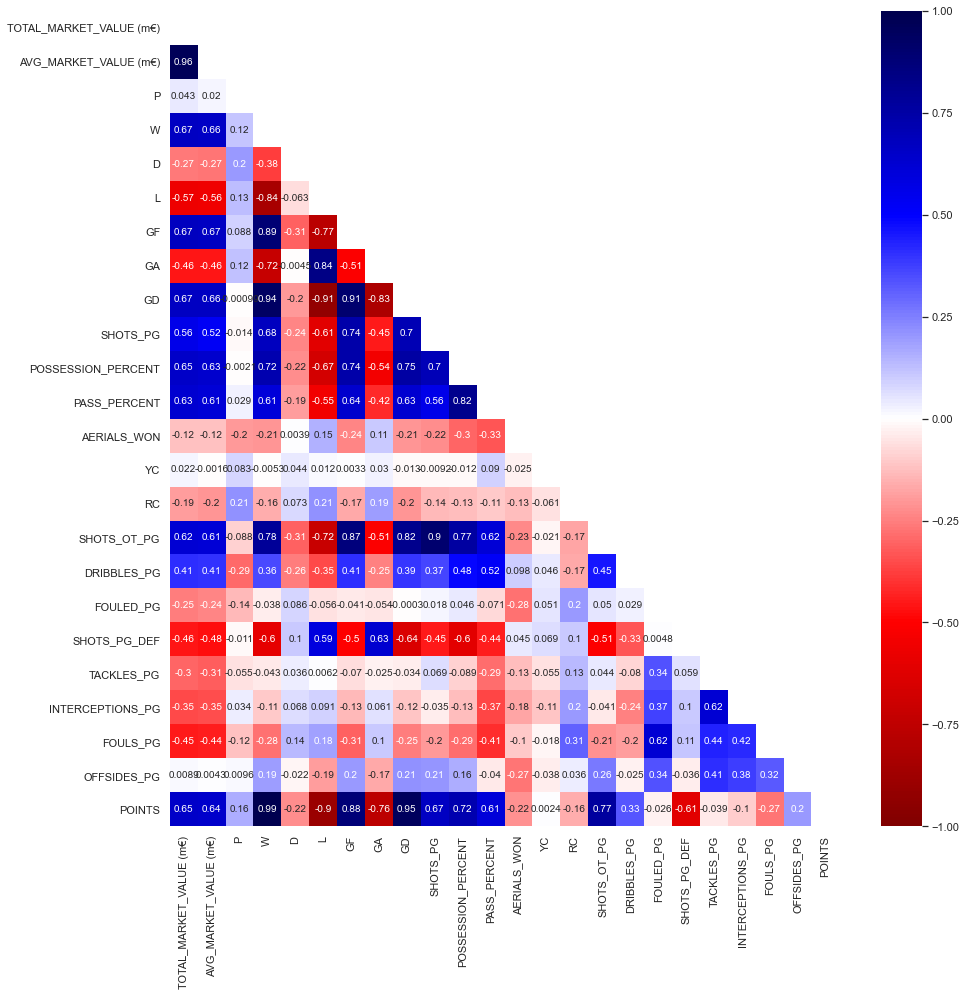

In [25]:
# View Heat Map
f, ax = plt.subplots(figsize=(15, 15))
upper = np.triu(new_leagues_df1.corr())  # optionally, you can just look at the lower triangle
sns.heatmap(new_leagues_df1.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1, mask=upper);

In [26]:
# Get correlations with POINTS sorted in descending order
new_leagues_df1.corr()['POINTS'].sort_values(ascending=False)

POINTS                     1.000000
W                          0.986095
GD                         0.951966
GF                         0.878582
SHOTS_OT_PG                0.769370
POSSESSION_PERCENT         0.723507
SHOTS_PG                   0.670068
TOTAL_MARKET_VALUE (m€)    0.654807
AVG_MARKET_VALUE (m€)      0.644215
PASS_PERCENT               0.605015
DRIBBLES_PG                0.331405
OFFSIDES_PG                0.198271
P                          0.157291
YC                         0.002395
FOULED_PG                 -0.025595
TACKLES_PG                -0.039438
INTERCEPTIONS_PG          -0.099773
RC                        -0.157196
AERIALS_WON               -0.217659
D                         -0.221759
FOULS_PG                  -0.268825
SHOTS_PG_DEF              -0.612464
GA                        -0.763889
L                         -0.896866
Name: POINTS, dtype: float64

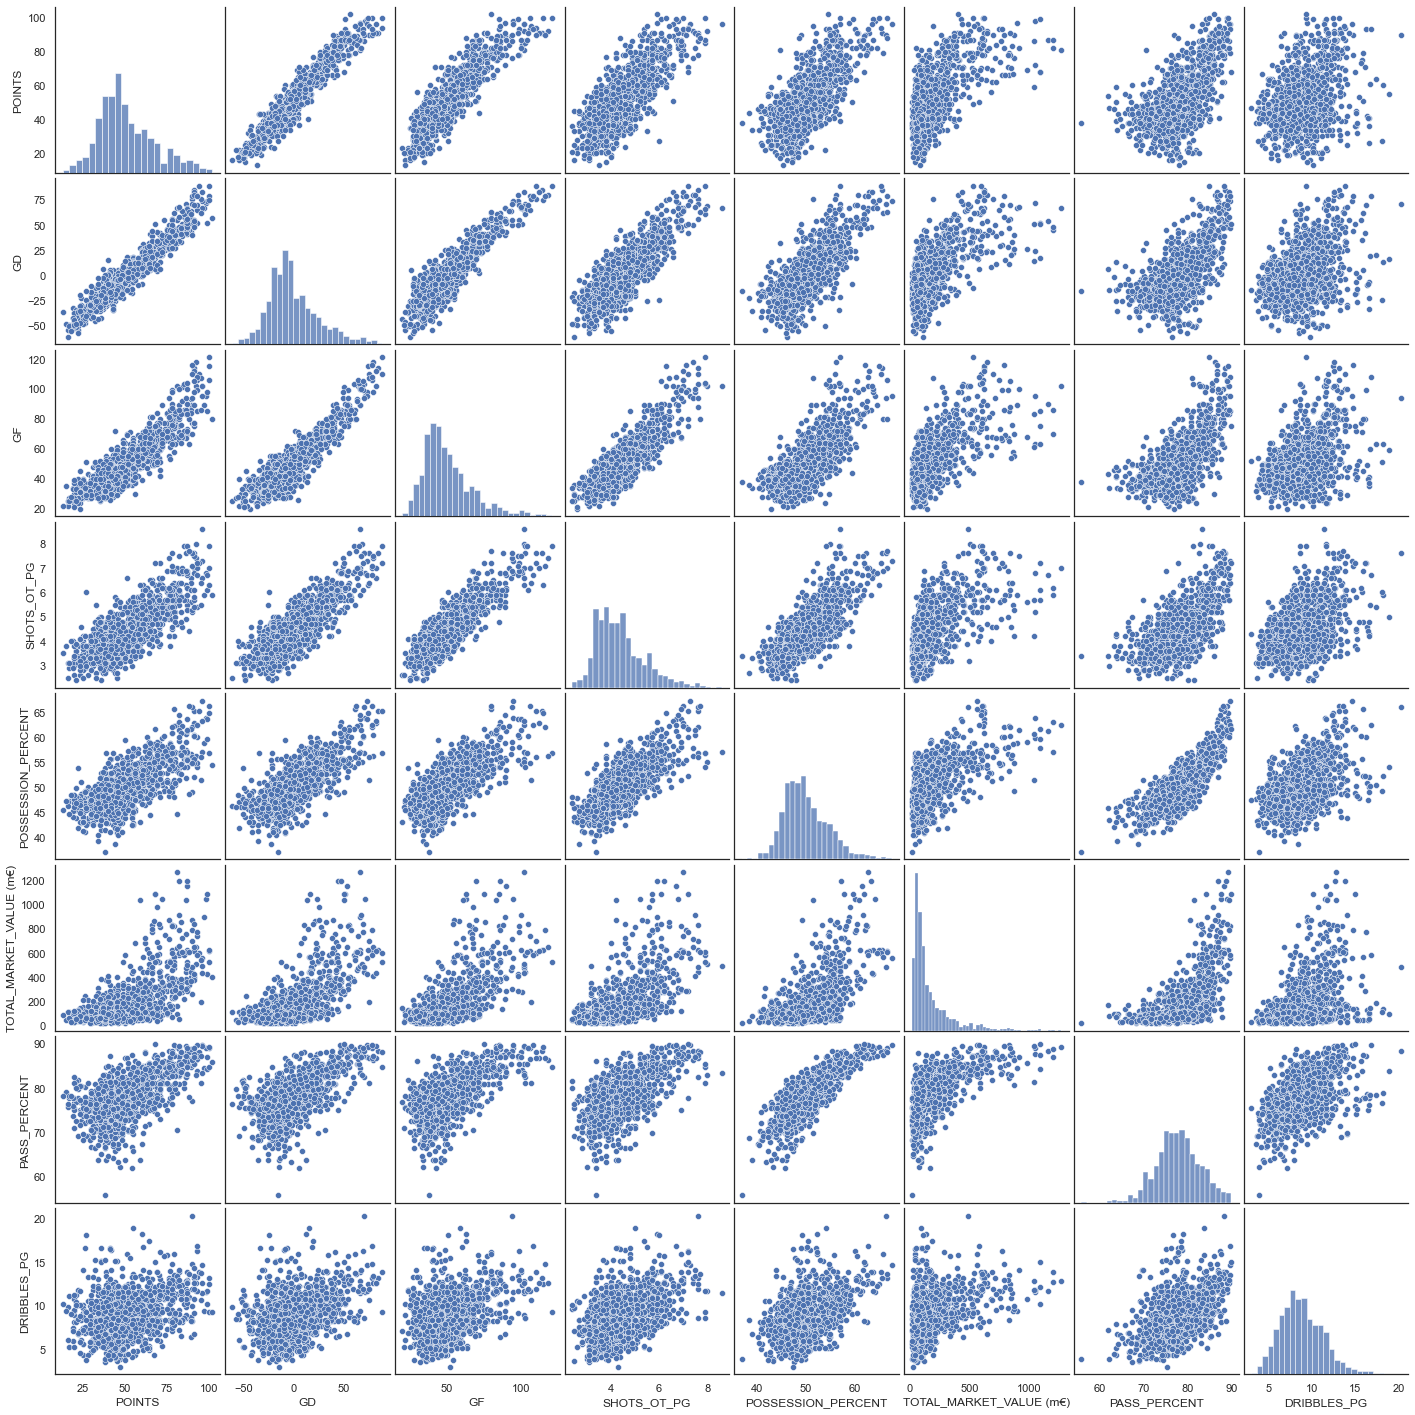

In [27]:
# Visualize some of the important pairwise correlations
sns.pairplot(new_leagues_df1[['POINTS','GD', 'GF', 'SHOTS_OT_PG', 'POSSESSION_PERCENT', 'TOTAL_MARKET_VALUE (m€)', 'PASS_PERCENT','DRIBBLES_PG']])

In [28]:
# GF shows a good linear relationship with POINTS
# Considering one feature - GF
# GOALS FOR vs POINTS

# 𝑌̂=𝛽̂0 + 𝛽̂1𝑋1

# Create an empty model
lr = LinearRegression()

X = new_leagues_df1['GF'].values.reshape(-1, 1)
y = new_leagues_df1['POINTS']
# Fit the model
lr.fit(X, y)

LinearRegression()

In [29]:
# Calculate R^2
# This implies that our model accounts for (R^2)% of the deviation of our y from the mean.
lr.score(X, y) # ==> 77.1% of the variance in y is captured/explained by the model.

0.7719068001176873

In [30]:
# Using statsmodel

# The Adjusted  𝑅^2 tries to limit overfitting by penalizing large coefficients and extra variables.
# It should not be used to evaluate a model on its own.
# It may be used as a measure of goodnes-of-fit to compare models

#Create the model
model = sm.OLS(y, sm.add_constant(X)) 
fit = model.fit()
fit.summary()

#The result shows that for every Goal scored, the number of points scored increases by 0.87 on average.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 POINTS   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     3973.
Date:                Thu, 10 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:38:37   Log-Likelihood:                -4106.5
No. Observations:                1176   AIC:                             8217.
Df Residuals:                    1174   BIC:                             8227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6437      0.740      8.982      0.000       5.193       8.095
x1             0.8763      0.014     63.032      0.000       0.849       0.904
==============================================================================
Omnibus:                       11.371   Durbin-Watson:                   1.418
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.229
Skew:                           0.189   Prob(JB):                      0.00221
Kurtosis:                       3.328   Cond. No.                         170.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# Diagnostics plotting

def diagnostic_plots(y_pred, y_true, resid):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    g1 = sns.regplot(x=y_pred, y=y_true, ci=False, fit_reg=False, line_kws={'color': 'blue'}, ax=axes[0], scatter_kws={'s': 5})
    g1.set_xlabel('Predicted Target')
    g1.set_ylabel('True Target')
    g1.plot(y_true, y_true, '--', color='gray')
    axes[0].set_title("Predicted Target vs. True Target")

    g2 = sns.regplot(x=y_pred, y=resid, lowess=True, ax=axes[1], line_kws={'color': 'red'}, scatter_kws={'s': 5})
    g2.set_xlabel('Predicted Target')
    g2.set_ylabel('Residual')
    g2.axhline(y=0, color='gray', linestyle='--')
    axes[1].set_title("Predictions vs. Residuals")

    stats.probplot(resid, dist="norm", plot=axes[2])
    axes[2].set_title('Norman Q-Q plot')

    #fig.suptitle('Diagnostic Plots');
    fig.tight_layout();

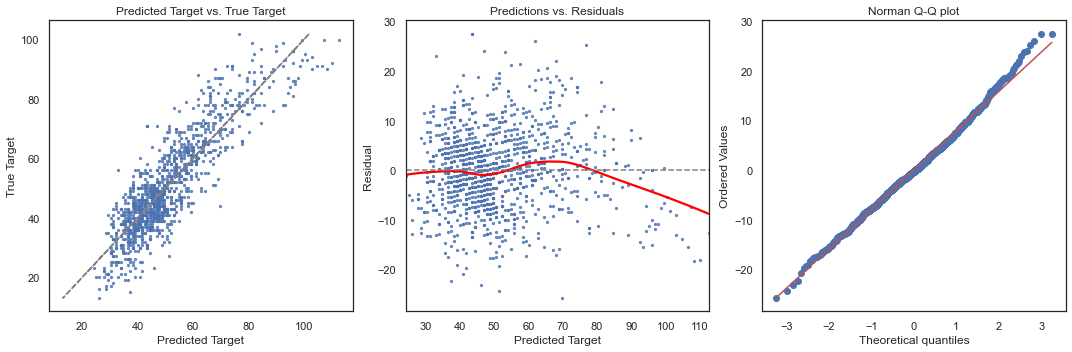

In [32]:
diagnostic_plots(fit.fittedvalues, y, fit.resid)

# The points appear to be well distrubuted around the gray line.
# The distribution of residual points from random fitting are randomly distributed around zero
# Points are very close to the line on the probability plot

In [33]:
# Based on the figue above, linear regression is a good starting point for developing a model.
# Adding multiple feature
# 𝑌̂=𝛽̂0+𝛽1𝑋1+𝛽̂2𝑋2 + ...

# Using 10 features that top the correlation matrix for POINTS
subset2=['GF','POSSESSION_PERCENT','SHOTS_PG','TOTAL_MARKET_VALUE (m€)',
         'PASS_PERCENT', 'OFFSIDES_PG','YC','TACKLES_PG',
         'INTERCEPTIONS_PG','AERIALS_WON', 'POINTS']

new_leagues_df2 = new_leagues_df[subset2]
new_leagues_df2.head()

,GF,POSSESSION_PERCENT,SHOTS_PG,TOTAL_MARKET_VALUE (m€),PASS_PERCENT,OFFSIDES_PG,YC,TACKLES_PG,INTERCEPTIONS_PG,AERIALS_WON,POINTS
0,103,56.9,21.9,443.90,82.5,2.5,54,20.3,18.6,11.6,86
1,86,55.6,18.3,362.95,79.9,2.2,49,21.8,15.8,13.2,85
2,83,57.0,17.4,281.00,80.8,2.4,56,21.5,22.1,14.4,75
3,67,52.2,17.9,249.20,76.1,3.1,58,22.2,21.2,18.2,70
4,73,52.2,13.8,314.90,76.0,3.2,49,21.1,21.2,12.7,67


In [34]:
#-------------------------------------------------------
# Backward elimination - Apply OLS and record R-squared
#-------------------------------------------------------

# 1. Significance level, SL = 0.05
# 2. Fit model with all features
# 3. Find feature with highest p-value
# 4. If p-value > SL, remove the feature
# 5. Fit the model without this feature and repeat the process.

X = new_leagues_df2.drop('POINTS',axis=1) # or new_leagues_df2[['X1','X2','X3',---]]
y = new_leagues_df2['POINTS']

#Create the model
model = sm.OLS(y, sm.add_constant(X)) 
fit = model.fit()
fit.summary()

# features      = [10, ]
# R_squared     = [0.790, ]
# R_squared_adj = [0.788, ]

# p-value < 0.05 indicates that we can reject the null hypothesis. 
# A feature with low -value is likely going to be a meaningful addition to the model.
# Changes in the feature are related to changes in the target.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 POINTS   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     438.5
Date:                Thu, 10 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:38:38   Log-Likelihood:                -4057.7
No. Observations:                1176   AIC:                             8137.
Df Residuals:                    1165   BIC:                             8193.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -18.0992      6.265     -2.889      0.004     -30.391      -5.808
GF                          0.7270      0.024     30.116      0.000       0.680       0.774
POSSESSION_PERCENT          0.5484      0.110      4.964      0.000       0.332       0.765
SHOTS_PG                   -0.2523      0.165     -1.526      0.127      -0.577       0.072
TOTAL_MARKET_VALUE (m€)     0.0099      0.002      5.409      0.000       0.006       0.013
PASS_PERCENT               -0.0234      0.096     -0.245      0.807      -0.211       0.164
OFFSIDES_PG                 0.3956      0.440      0.899      0.369      -0.468       1.259
YC                          0.0040      0.010      0.413      0.680      -0.015       0.023
TACKLES_PG                  0.2375      0.110      2.155      0.031       0.021       0.454
INTERCEPTIONS_PG            0.0994      0.072      1.373      0.170      -0.043       0.241
AERIALS_WON                 0.0623      0.054      1.152      0.249      -0.044       0.168
==============================================================================
Omnibus:                        8.373   Durbin-Watson:                   1.489
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.563
Skew:                           0.171   Prob(JB):                       0.0138
Kurtosis:                       3.240   Cond. No.                     7.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
# Max p-value was 0.68 (>0.05) for YC
# Drop YC

X = X.drop('YC',axis=1) 
y = new_leagues_df2['POINTS']

#Create the model
model = sm.OLS(y, sm.add_constant(X)) 
fit = model.fit()
fit.summary()

# features      = [10,   9 ]
# R_squared     = [0.790, 0.790]
# R_squared_adj = [0.788, 0.788 ]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 POINTS   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     487.6
Date:                Thu, 10 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:38:38   Log-Likelihood:                -4057.7
No. Observations:                1176   AIC:                             8135.
Df Residuals:                    1166   BIC:                             8186.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -17.9999      6.258     -2.876      0.004     -30.278      -5.722
GF                          0.7270      0.024     30.127      0.000       0.680       0.774
POSSESSION_PERCENT          0.5433      0.110      4.951      0.000       0.328       0.759
SHOTS_PG                   -0.2523      0.165     -1.526      0.127      -0.577       0.072
TOTAL_MARKET_VALUE (m€)     0.0098      0.002      5.407      0.000       0.006       0.013
PASS_PERCENT               -0.0183      0.095     -0.192      0.847      -0.205       0.168
OFFSIDES_PG                 0.3990      0.440      0.907      0.364      -0.464       1.262
TACKLES_PG                  0.2388      0.110      2.168      0.030       0.023       0.455
INTERCEPTIONS_PG            0.0977      0.072      1.352      0.177      -0.044       0.239
AERIALS_WON                 0.0620      0.054      1.148      0.251      -0.044       0.168
==============================================================================
Omnibus:                        8.492   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.696
Skew:                           0.172   Prob(JB):                       0.0129
Kurtosis:                       3.242   Cond. No.                     7.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
# Max p-value was 0.847 (>0.05) for PASS_PERCENT
# Drop PASS_PERCENT

X = X.drop('PASS_PERCENT',axis=1) 
y = new_leagues_df2['POINTS']

#Create the model
model = sm.OLS(y, sm.add_constant(X)) 
fit = model.fit()
fit.summary()

# features      = [10,    9,     8, ]
# R_squared     = [0.790, 0.790, 0.790]
# R_squared_adj = [0.788, 0.788, 0.789 ]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 POINTS   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     549.0
Date:                Thu, 10 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:38:38   Log-Likelihood:                -4057.8
No. Observations:                1176   AIC:                             8134.
Df Residuals:                    1167   BIC:                             8179.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -18.9174      4.053     -4.668      0.000     -26.869     -10.966
GF                          0.7267      0.024     30.181      0.000       0.680       0.774
POSSESSION_PERCENT          0.5297      0.084      6.329      0.000       0.365       0.694
SHOTS_PG                   -0.2523      0.165     -1.527      0.127      -0.577       0.072
TOTAL_MARKET_VALUE (m€)     0.0098      0.002      5.406      0.000       0.006       0.013
OFFSIDES_PG                 0.4142      0.432      0.958      0.338      -0.434       1.263
TACKLES_PG                  0.2407      0.110      2.196      0.028       0.026       0.456
INTERCEPTIONS_PG            0.1021      0.069      1.490      0.137      -0.032       0.237
AERIALS_WON                 0.0654      0.051      1.281      0.201      -0.035       0.166
==============================================================================
Omnibus:                        8.389   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.581
Skew:                           0.171   Prob(JB):                       0.0137
Kurtosis:                       3.240   Cond. No.                     4.85e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.85e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
# Max p-value was 0.338 (>0.05) for OFFSIDES_PG
# Drop OFFSIDES_PG

X = X.drop('OFFSIDES_PG',axis=1) 
y = new_leagues_df2['POINTS']

#Create the model
model = sm.OLS(y, sm.add_constant(X)) 
fit = model.fit()
fit.summary()

# features      = [10,    9,     8,     7, ]
# R_squared     = [0.790, 0.790, 0.790, 0.790]
# R_squared_adj = [0.788, 0.788, 0.789, 0.789 ]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 POINTS   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     627.3
Date:                Thu, 10 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:38:38   Log-Likelihood:                -4058.2
No. Observations:                1176   AIC:                             8132.
Df Residuals:                    1168   BIC:                             8173.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -18.6992      4.046     -4.621      0.000     -26.638     -10.761
GF                          0.7297      0.024     30.547      0.000       0.683       0.777
POSSESSION_PERCENT          0.5304      0.084      6.337      0.000       0.366       0.695
SHOTS_PG                   -0.2515      0.165     -1.522      0.128      -0.576       0.073
TOTAL_MARKET_VALUE (m€)     0.0098      0.002      5.410      0.000       0.006       0.013
TACKLES_PG                  0.2658      0.106      2.497      0.013       0.057       0.475
INTERCEPTIONS_PG            0.1139      0.067      1.691      0.091      -0.018       0.246
AERIALS_WON                 0.0577      0.050      1.143      0.253      -0.041       0.157
==============================================================================
Omnibus:                        8.517   Durbin-Watson:                   1.491
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                8.696
Skew:                           0.174   Prob(JB):                       0.0129
Kurtosis:                       3.237   Cond. No.                     4.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
# Max p-value was 0.253 (>0.05) for AERIALS_WON
# Drop AERIALS_WON

X = X.drop('AERIALS_WON',axis=1) 
y = new_leagues_df2['POINTS']

#Create the model
model = sm.OLS(y, sm.add_constant(X)) 
fit = model.fit()
fit.summary()

# features      = [10,    9,     8,     7,     6 ]
# R_squared     = [0.790, 0.790, 0.790, 0.790, 0.790]
# R_squared_adj = [0.788, 0.788, 0.789, 0.789, 0.789 ]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 POINTS   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     731.4
Date:                Thu, 10 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:38:38   Log-Likelihood:                -4058.9
No. Observations:                1176   AIC:                             8132.
Df Residuals:                    1169   BIC:                             8167.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -16.5351      3.576     -4.623      0.000     -23.552      -9.518
GF                          0.7284      0.024     30.523      0.000       0.682       0.775
POSSESSION_PERCENT          0.5103      0.082      6.235      0.000       0.350       0.671
SHOTS_PG                   -0.2471      0.165     -1.496      0.135      -0.571       0.077
TOTAL_MARKET_VALUE (m€)     0.0099      0.002      5.447      0.000       0.006       0.013
TACKLES_PG                  0.2629      0.106      2.470      0.014       0.054       0.472
INTERCEPTIONS_PG            0.1016      0.067      1.528      0.127      -0.029       0.232
==============================================================================
Omnibus:                        7.924   Durbin-Watson:                   1.496
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                8.029
Skew:                           0.169   Prob(JB):                       0.0180
Kurtosis:                       3.222   Cond. No.                     4.28e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
# Max p-value was 0.135 (>0.05) for SHOTS_PG
# Drop SHOTS_PG

X = X.drop('SHOTS_PG',axis=1) 
y = new_leagues_df2['POINTS']

#Create the model
model = sm.OLS(y, sm.add_constant(X)) 
fit = model.fit()
fit.summary()

# n_features    = [10,    9,     8,     7,     6,    5]
# R_squared     = [0.790, 0.790, 0.790, 0.790, 0.790, 0.789]
# R_squared_adj = [0.788, 0.788, 0.789, 0.789, 0.789, 0.788]
# Feature_Dropped = [ YC, PASS_PERCENT, OFFSIDES_PG, AERIALS_WON, SHOTS_PG]

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 POINTS   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     876.4
Date:                Thu, 10 Jun 2021   Prob (F-statistic):               0.00
Time:                        09:38:38   Log-Likelihood:                -4060.0
No. Observations:                1176   AIC:                             8132.
Df Residuals:                    1170   BIC:                             8162.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -16.3819      3.577     -4.580      0.000     -23.400      -9.364
GF                          0.7137      0.022     32.799      0.000       0.671       0.756
POSSESSION_PERCENT          0.4714      0.078      6.072      0.000       0.319       0.624
TOTAL_MARKET_VALUE (m€)     0.0097      0.002      5.329      0.000       0.006       0.013
TACKLES_PG                  0.2325      0.105      2.224      0.026       0.027       0.438
INTERCEPTIONS_PG            0.1015      0.067      1.525      0.128      -0.029       0.232
==============================================================================
Omnibus:                        8.817   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                9.048
Skew:                           0.176   Prob(JB):                       0.0108
Kurtosis:                       3.247   Cond. No.                     4.27e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.27e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
# Note that R_squared_adj decreased to 0.788 from 0.789. Thus SHOTS_PG is an important feature and cannot be dropped..
# R_squared_adj increases only if the added feature improves the model more than would be expected by chance.
# The value will decrease when a featureimproves the model by less than expected by chance.

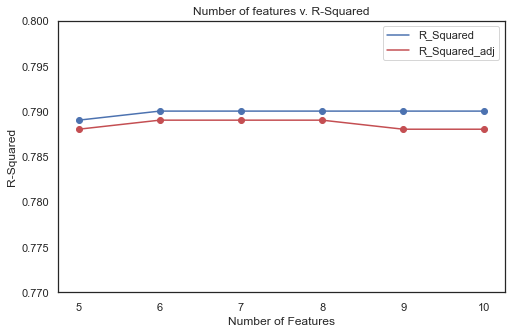

In [41]:
# Plot of R-squared and R-squared_adj

n_features    = [10,    9,     8,     7,     6,    5]
R_squared     = [0.790, 0.790, 0.790, 0.790, 0.790, 0.789]
R_squared_adj = [0.788, 0.788, 0.789, 0.789, 0.789, 0.788]
# Feature_Dropped = [ YC, PASS_PERCENT, OFFSIDES_PG, AERIALS_WON, SHOTS_PG]

sns.set_theme(style="white")
fig, ax = plt.subplots( figsize=(8, 5))
ax.plot(n_features,R_squared,'bo')
ax.plot(n_features,R_squared,'b-', label='R_Squared')
ax.set_ylabel('R-Squared')
ax.set_xlabel('Number of Features')
ax.set_title('Number of features v. R-Squared')
ax.set_ylim(0.77, 0.8)

ax.plot(n_features,R_squared_adj,'ro')
ax.plot(n_features,R_squared_adj,'r-', label='R_Squared_adj')
#lns = [R-Squared, p2, p3]
ax.legend(loc='best');
#ax.tick_params(axis='y', labelcolor=color)

In [42]:
# Six features that influence total points considerably

subset3 = ['GF','POSSESSION_PERCENT','SHOTS_PG','TOTAL_MARKET_VALUE (m€)',
           'TACKLES_PG','INTERCEPTIONS_PG', 'POINTS']

small_leagues_df = new_leagues_df2[subset3]
small_leagues_df.head()

,GF,POSSESSION_PERCENT,SHOTS_PG,TOTAL_MARKET_VALUE (m€),TACKLES_PG,INTERCEPTIONS_PG,POINTS
0,103,56.9,21.9,443.90,20.3,18.6,86
1,86,55.6,18.3,362.95,21.8,15.8,85
2,83,57.0,17.4,281.00,21.5,22.1,75
3,67,52.2,17.9,249.20,22.2,21.2,70
4,73,52.2,13.8,314.90,21.1,21.2,67


In [59]:
#
# FEATURES ENGINEERING
#
# Find polynomial interactions with the most weight.

small_leagues_df.head()

,GF,POSSESSION_PERCENT,SHOTS_PG,TOTAL_MARKET_VALUE (m€),TACKLES_PG,INTERCEPTIONS_PG,POINTS
0,103,56.9,21.9,443.90,20.3,18.6,86
1,86,55.6,18.3,362.95,21.8,15.8,85
2,83,57.0,17.4,281.00,21.5,22.1,75
3,67,52.2,17.9,249.20,22.2,21.2,70
4,73,52.2,13.8,314.90,21.1,21.2,67


In [60]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    train_score = lr_model.score(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nTrain R^2 score was     :', train_score)
    print('\nValidation R^2 score was:', val_score)
    print('\ny-intercept:', lr_model.intercept_)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.3f}') 

In [61]:
X = small_leagues_df.drop('POINTS',axis=1)
y = small_leagues_df['POINTS']

In [62]:
# Split and validate
split_and_validate(X, y)


Train R^2 score was     : 0.7979110376830532

Validation R^2 score was: 0.7574827899929757

y-intercept: -15.646842100962537
Feature coefficient results: 

GF : 0.725
POSSESSION_PERCENT : 0.468
SHOTS_PG : -0.185
TOTAL_MARKET_VALUE (m€) : 0.011
TACKLES_PG : 0.264
INTERCEPTIONS_PG : 0.128


In [63]:
# Add Polynomial term for GF2 and SHOTS_PG

X2 = X.copy()

X2['GF2'] = X2['GF'] ** 2 
X2['SHOTS_PG2'] = X2['SHOTS_PG'] ** 2

split_and_validate(X2, y) # 0.7682237133610057


Train R^2 score was     : 0.8058867472500675

Validation R^2 score was: 0.7682237133610057

y-intercept: -21.17007589732345
Feature coefficient results: 

GF : 1.167
POSSESSION_PERCENT : 0.460
SHOTS_PG : -1.132
TOTAL_MARKET_VALUE (m€) : 0.012
TACKLES_PG : 0.285
INTERCEPTIONS_PG : 0.125
GF2 : -0.004
SHOTS_PG2 : 0.033


In [64]:
# Split and validate #3 - Adding logarithmic term
# TOTAL_MARKET_VALUE (m€) looks like a logarithmic function

X3 = X2.copy()
#X3['TOTAL_MARKET_VALUE (m€)_LOG'] = np.log(X3['TOTAL_MARKET_VALUE (m€)'])   # log_e = ln ---> 0.9193859286401057
X3['TOTAL_MARKET_VALUE (m€)_LOG'] = np.log10(X3['TOTAL_MARKET_VALUE (m€)']) # log_10      ---> 0.9193859286401059
#X3['TOTAL_MARKET_VALUE (m€)_LOG'] = np.log2(X3['TOTAL_MARKET_VALUE (m€)'])  # log_2      ---> 0.9193859286401059

split_and_validate(X3, y) # Validation R^2 improved slightly.


Train R^2 score was     : 0.8063112638303571

Validation R^2 score was: 0.7688054266560345

y-intercept: -23.522848177260165
Feature coefficient results: 

GF : 1.142
POSSESSION_PERCENT : 0.456
SHOTS_PG : -1.235
TOTAL_MARKET_VALUE (m€) : 0.009
TACKLES_PG : 0.300
INTERCEPTIONS_PG : 0.136
GF2 : -0.004
SHOTS_PG2 : 0.035
TOTAL_MARKET_VALUE (m€)_LOG : 2.089


In [65]:
# The MODEL from Feature engineering is
#
# y = -23.522 + 1.142X1 + 0.456X2 -1.235X3 +0.009X4 + 0.3X5 + 0.136X6 - 0.004X7 + 0.035X8 + 2.089X9 
# 

In [95]:
#---------------------------------------------------------------------
# Simple validation method: Train(60%) / Validation(20%) / Test(20%)
# RIDGE alpha = 1.0
#------------------------------------------------------------------------

X = X3
#X = small_leagues_df.drop('POINTS',axis=1)
y = small_leagues_df['POINTS']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=11) # state = 10

# Partition once more to get 20% of training
# further partition X, y into datasets X_train, y_train (60% of original) and X_val, y_val (20%).
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [96]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each feature
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values) # Fits data and then transforms it.
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [97]:
# validate

lm.fit(X_train, y_train)

print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression train R^2: 0.786
Linear Regression val R^2: 0.831
Ridge Regression val R^2: 0.829
Degree 2 polynomial regression val R^2: 0.803


In [98]:
# Retrain it on the entire chunk of train/val data (X,y) and see how it does on test data(X_test,y_test):
    
lm.fit(X,y)
print(f'Linear Regression train/val R^2: {lm.score(X, y):.3f}')
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression train/val R^2: 0.800
Linear Regression test R^2: 0.792


In [99]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))


Linear Regression (train/val) R^2: 0.800
Linear Regression test R^2     : 0.792

Root Mean Square (RMSE) (train/val): 7.419
Root Mean Square (RMSE) test         : 7.678

Mean Absolute Error (MAE) (train/val): 5.870
Mean Absolute Error (MAE) test         : 6.048


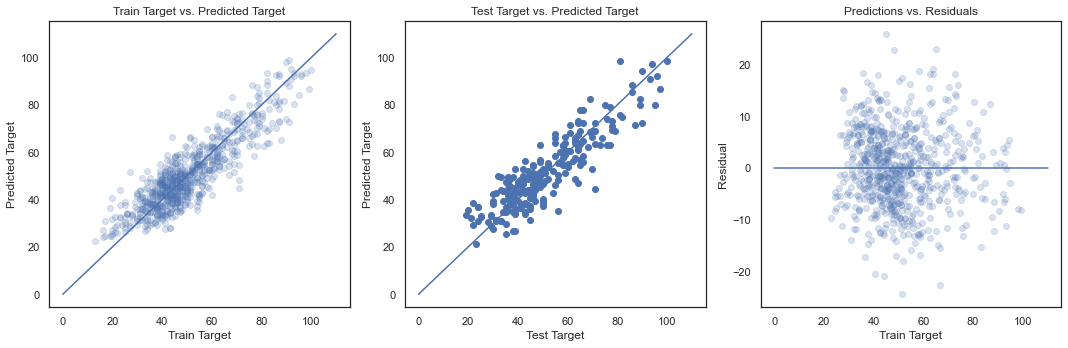

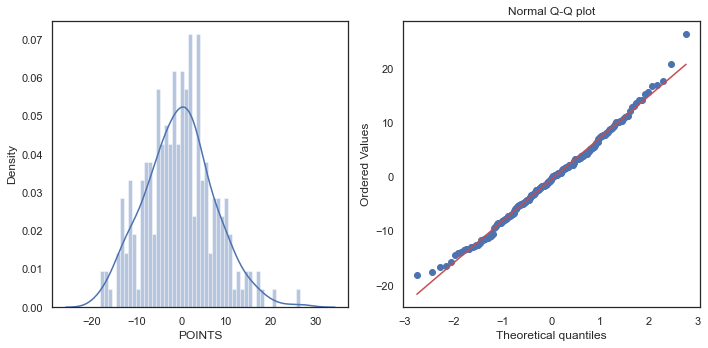

In [100]:
y_train_pred = lm.predict(X_train)
y_test_pred  = lm.predict(X_test)
    
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
# Train vs. Fitted
axes[0].scatter(y_train, y_train_pred, alpha=0.2)
axes[0].plot([0,110],[0,110])
axes[0].set_xlabel('Train Target')
axes[0].set_ylabel('Predicted Target')
axes[0].set_title("Train Target vs. Predicted Target")
    
# Test vs. Fitted
axes[1].scatter(y_test, y_test_pred)
axes[1].plot([0,110],[0,110])
axes[1].set_xlabel('Test Target')
axes[1].set_ylabel('Predicted Target')
axes[1].set_title("Test Target vs. Predicted Target")
    
# Plot Residuals vs. predicted
lin_reg_residuals = y_train - y_train_pred

axes[2].scatter(y_train_pred, lin_reg_residuals, alpha=0.2)
axes[2].plot([0,110], [0, 0])
axes[2].set_xlabel('Train Target')
axes[2].set_ylabel('Residual')
axes[2].set_title("Predictions vs. Residuals")

#fig.suptitle('Diagnostic Plots');
fig.tight_layout();
    
y_train_val_pred = lm.predict(X)
y_test_pred  = lm.predict(X_test) 
residual_test = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
g1 = sns.distplot(residual_test, bins = 50, ax=axes[0])
stats.probplot(residual_test, dist="norm", plot=axes[1])
axes[1].set_title('Normal Q-Q plot')

fig.tight_layout();
    
# prediction on trainig model
RMSE = sqrt(mean_squared_error(y,y_train_val_pred))
MAE  = mean_absolute_error(y,y_train_val_pred)
# prediction on test model
RMSE1 = sqrt(mean_squared_error(y_test,y_test_pred))
MAE1   = mean_absolute_error(y_test,y_test_pred)

print(f'\nLinear Regression (train/val) R^2: {lm.score(X, y):.3f}')
print(f'Linear Regression test R^2     : {lm.score(X_test, y_test):.3f}')
    
print(f'\nRoot Mean Square (RMSE) (train/val): {RMSE:.3f}')
print(f'Root Mean Square (RMSE) test         : {RMSE1:.3f}')
    
print(f'\nMean Absolute Error (MAE) (train/val): {MAE:.3f}')
print(f'Mean Absolute Error (MAE) test         : {MAE1:.3f}') # 5.870

In [149]:
#----------------------------------------------------- 
# Rigorous Validation Method: Cross-Validation / Test
#-----------------------------------------------------

X = X3
#X = small_leagues_df.drop('POINTS',axis=1)
y = small_leagues_df['POINTS']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [150]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val).round(3))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val).round(3))

print(f'Simple Linear Regression scores: \t{cv_lm_r2s}')
print(f'Ridge Regression scores        : \t{cv_lm_reg_r2s} \n')

print(f'Simple mean cv r^2 val: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2 val: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple Linear Regression scores: 	[0.816, 0.804, 0.83, 0.758, 0.769]
Ridge Regression scores        : 	[0.816, 0.804, 0.829, 0.759, 0.768] 

Simple mean cv r^2 val: 0.795 +- 0.028
Ridge mean cv r^2 val: 0.795 +- 0.027


In [203]:
# Get a Ridge model from train/val (X) and score test(X_test)
# Overall, k-fold is more reliable than a single validation set, 
# we select the ridge regression model

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.779



Ridge Cross Validation/Test (train/val) R^2 : 0.803
Ridge Cross Validation/Test (test) R^2        : 0.779

Root Mean Square (RMSE) (train/val): 7.526
Root Mean Square (RMSE) test         : 7.246

Mean Absolute Error (MAE) (train/val): 5.969
Mean Absolute Error (MAE) test         : 5.683


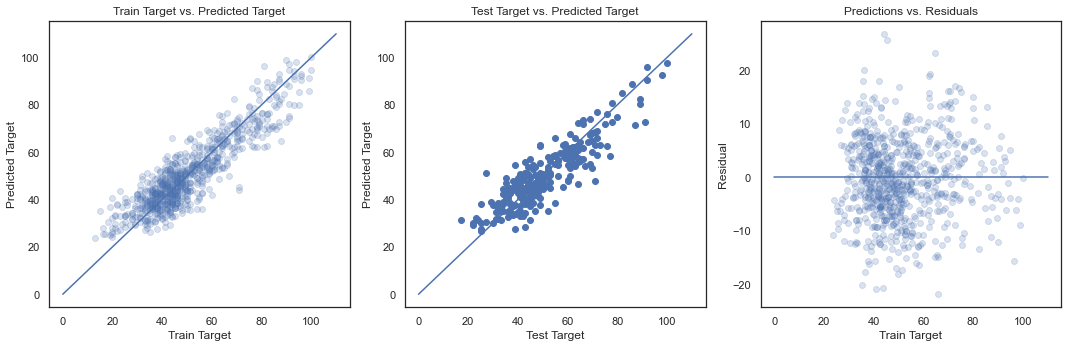

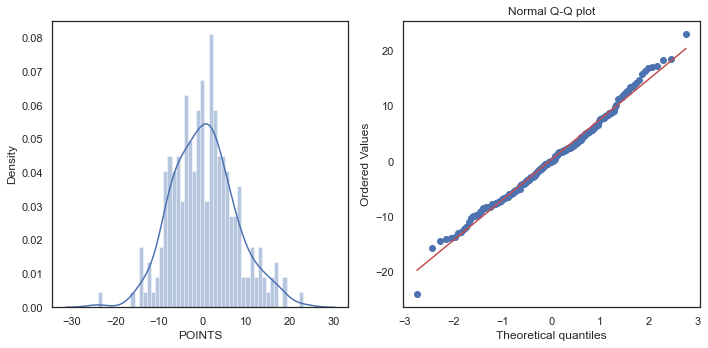

In [148]:
y_train_pred = lm_reg.predict(X_train_scaled)
y_test_pred  = lm_reg.predict(X_test_scaled)
    
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
# Train vs. Fitted
axes[0].scatter(y_train, y_train_pred, alpha=0.2)
axes[0].plot([0,110],[0,110])
axes[0].set_xlabel('Train Target')
axes[0].set_ylabel('Predicted Target')
axes[0].set_title("Train Target vs. Predicted Target")
    
# Test vs. Fitted
axes[1].scatter(y_test, y_test_pred)
axes[1].plot([0,110],[0,110])
axes[1].set_xlabel('Test Target')
axes[1].set_ylabel('Predicted Target')
axes[1].set_title("Test Target vs. Predicted Target")
    
# Plot Residuals vs. predicted
lin_reg_residuals = y_train - y_train_pred

axes[2].scatter(y_train_pred, lin_reg_residuals, alpha=0.2)
axes[2].plot([0,110], [0, 0])
axes[2].set_xlabel('Train Target')
axes[2].set_ylabel('Residual')
axes[2].set_title("Predictions vs. Residuals")

#fig.suptitle('Diagnostic Plots');
fig.tight_layout();

y_train_val_pred = lm_reg.predict(X_scaled)
y_test_pred  = lm_reg.predict(X_test_scaled) 
residual_test = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
g1 = sns.distplot(residual_test, bins = 50, ax=axes[0])
stats.probplot(residual_test, dist="norm", plot=axes[1])
axes[1].set_title('Normal Q-Q plot')

fig.tight_layout();

# prediction on trainig model
RMSE = sqrt(mean_squared_error(y,y_train_val_pred))
MAE  = mean_absolute_error(y,y_train_val_pred)
# prediction on test model
RMSE1 = sqrt(mean_squared_error(y_test,y_test_pred))
MAE1   = mean_absolute_error(y_test,y_test_pred)

print(f'\nRidge Cross Validation/Test (train/val) R^2 : {lm_reg.score(X_scaled, y):.3f}')
print(f'Ridge Cross Validation/Test (test) R^2        : {lm_reg.score(X_test_scaled, y_test):.3f}')
    
print(f'\nRoot Mean Square (RMSE) (train/val): {RMSE:.3f}')
print(f'Root Mean Square (RMSE) test         : {RMSE1:.3f}')
    
print(f'\nMean Absolute Error (MAE) (train/val): {MAE:.3f}')
print(f'Mean Absolute Error (MAE) test         : {MAE1:.3f}') # 5.870

In [136]:
# Obvious over fittig from the lower R^2 test.
# Apply regularization to help reduce overfitting and colinearity.

#-----------------
# REGULARIZATION
#-----------------
# Practical strategy for reducing overfitting by punishing model complexity.
# We search for a model that is elaborate enough to describe the feature-target relationship (not underfit), 
# but not so elaborate that it fits to spurious patterns in the training data (not overfit)

X = X3
#X = small_leagues_df.drop('POINTS',axis=1)
y = small_leagues_df['POINTS']

#Split the data 60 - 20 - 20 train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

Minimum Error : 5.594817689575498
Alpha with minimum error : 1.3509935211980264


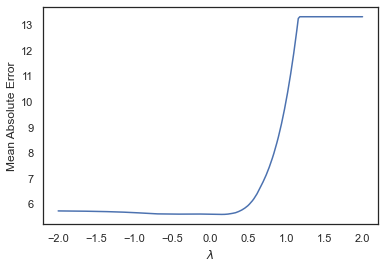

In [137]:
#------------------------------------------------------
# Tuning Regularization Strength via Validation - LASSO
#------------------------------------------------------

# Combine standard scaling
# Apply scalar to training and test data sets,
# Fit LASSO/RIDGE model

alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)
    
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)
plt.xlabel (r'$\lambda$')
plt.ylabel('Mean Absolute Error')

## Minimum error achieved on the validation set across the different alpha values we tried

print(f'Minimum Error : {np.min(err_vec_val)}')

## This is the value of alpha that gave us the lowest error
print(f'Alpha with minimum error : {alphalist[np.argmin(err_vec_val)]}')



Minimum Error : 5.707383610819946
Alpha with minimum error : 43.470131581250264


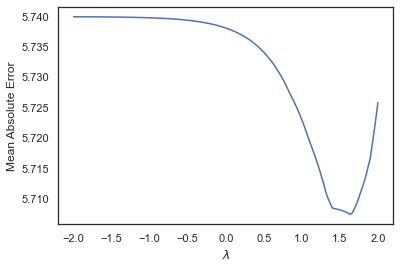

In [138]:
#------------------------------------------------------
# Tuning Regularization Strength via Validation - RIDGE
#------------------------------------------------------

# Combine standard scaling
# Apply scalar to training and test data sets,
# Fit LASSO/RIDGE model

alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('ridge', Ridge(alpha = curr_alpha))]

    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
    val_set_pred = pipe.predict(X_val)
    err_vec_val[i] = mae(y_val, val_set_pred)
    
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)
plt.xlabel (r'$\lambda$')
plt.ylabel('Mean Absolute Error')

## Minimum error achieved on the validation set across the different alpha values we tried

print(f'Minimum Error : {np.min(err_vec_val)}')

## This is the value of alpha that gave us the lowest error
print(f'Alpha with minimum error : {alphalist[np.argmin(err_vec_val)]}')

In [139]:
#----------------------------------------------------------------------
# Automated Regularization Strength Tuning via Cross-validation - LASSO
#----------------------------------------------------------------------

## Scale the data
std = StandardScaler()
std.fit(X_train.values)

## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [140]:
# This is the best alpha value it found
# Compare with alpha from simple validation
print(f'Alpha with minimum error : {lasso_model.alpha_}') # this value is same as value from simple validation
print('\n')

# These are the (standardized) coefficients found when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

Alpha with minimum error : 0.01




[('GF', 11.986868183026106),
 ('POSSESSION_PERCENT', 2.1913950169341083),
 ('SHOTS_PG', -0.9369893358350321),
 ('TOTAL_MARKET_VALUE (m€)', 2.4311109145242),
 ('TACKLES_PG', 0.5216158296539236),
 ('INTERCEPTIONS_PG', 0.7967957329264954)]


LASSO Regularization (train set) R^2 : 0.7915691170764868
LASSO Regularization (test set) R^2    : 0.7566482771838899

Root Mean Square (RMSE) (train/val): 7.497
Root Mean Square (RMSE) test         : 8.409

Mean Absolute Error (MAE) (train/val): 5.970
Mean Absolute Error (MAE) test         : 6.593


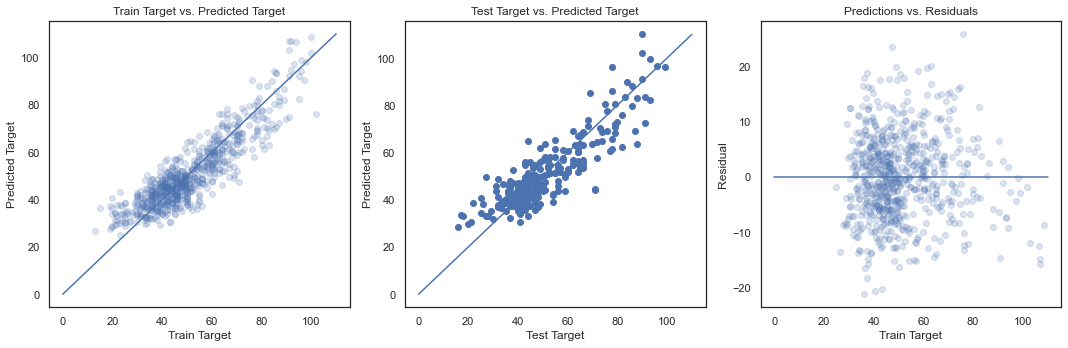

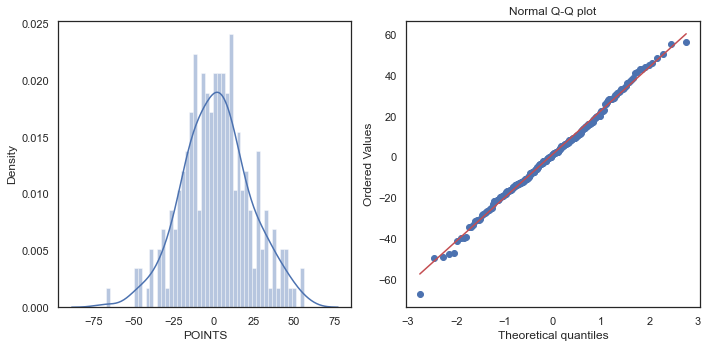

In [141]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)
train_set_pred = lasso_model.predict(X_tr)
    
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
# Train vs. Fitted
axes[0].scatter(y_train, train_set_pred, alpha=0.2)
axes[0].plot([0,110],[0,110])
axes[0].set_xlabel('Train Target')
axes[0].set_ylabel('Predicted Target')
axes[0].set_title("Train Target vs. Predicted Target")
    
# Test vs. Fitted
axes[1].scatter(y_test, test_set_pred)
axes[1].plot([0,110],[0,110])
axes[1].set_xlabel('Test Target')
axes[1].set_ylabel('Predicted Target')
axes[1].set_title("Test Target vs. Predicted Target")
    
# Plot Residuals vs. predicted
lin_reg_residuals = y_train - train_set_pred

axes[2].scatter(train_set_pred, lin_reg_residuals, alpha=0.2)
axes[2].plot([0,110], [0, 0])
axes[2].set_xlabel('Train Target')
axes[2].set_ylabel('Residual')
axes[2].set_title("Predictions vs. Residuals")

#fig.suptitle('Diagnostic Plots');
fig.tight_layout();

y_train_val_pred = lm_reg.predict(X_scaled)
y_test_pred  = lm_reg.predict(X_test_scaled) 
residual_test = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
g1 = sns.distplot(residual_test, bins = 50, ax=axes[0])
stats.probplot(residual_test, dist="norm", plot=axes[1])
axes[1].set_title('Normal Q-Q plot')

fig.tight_layout();


# prediction on trainig model
RMSE = sqrt(mean_squared_error(y_train,train_set_pred))
MAE  = mean_absolute_error(y_train,train_set_pred)
# prediction on test model
RMSE1 = sqrt(mean_squared_error(y_test,test_set_pred))
MAE1   = mean_absolute_error(y_test,test_set_pred)

print(f'\nLASSO Regularization (train set) R^2 : {r2_score(y_train, train_set_pred)}')
print(f'LASSO Regularization (test set) R^2    : {r2_score(y_test, test_set_pred)}')
    
print(f'\nRoot Mean Square (RMSE) (train/val): {RMSE:.3f}')
print(f'Root Mean Square (RMSE) test         : {RMSE1:.3f}')
    
print(f'\nMean Absolute Error (MAE) (train/val): {MAE:.3f}')
print(f'Mean Absolute Error (MAE) test         : {MAE1:.3f}') # 5.870

In [142]:
#----------------------------------------------------------------------
# Automated Regularization Strength Tuning via Cross-validation - RIDGE
#----------------------------------------------------------------------

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [143]:
print(f'Alpha with minimum error : {ridge_model.alpha_}') # this value is same as value from simple validation
print('\n')

# These are the (standardized) coefficients found when it refit using that best alpha
list(zip(X_train.columns, ridge_model.coef_))

Alpha with minimum error : 4.297004704320839




[('GF', 11.81174540127404),
 ('POSSESSION_PERCENT', 2.243471084817418),
 ('SHOTS_PG', -0.8762259489793418),
 ('TOTAL_MARKET_VALUE (m€)', 2.478729382914936),
 ('TACKLES_PG', 0.5289865196611129),
 ('INTERCEPTIONS_PG', 0.8023812264272766)]


RIDGE Regularization (train set) R^2 : 0.7915221937674155
RIDGE Regularization (test set) R^2    : 0.7565548602921474

Root Mean Square (RMSE) (train/val): 7.498
Root Mean Square (RMSE) test         : 8.411

Mean Absolute Error (MAE) (train/val): 5.971
Mean Absolute Error (MAE) test         : 6.597


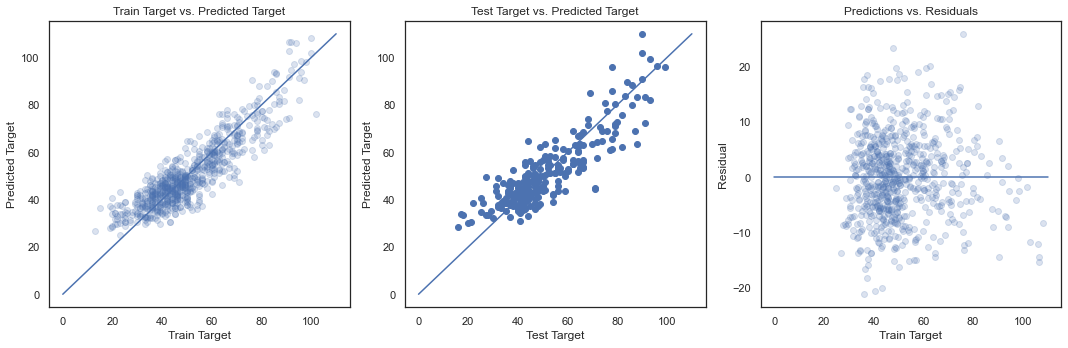

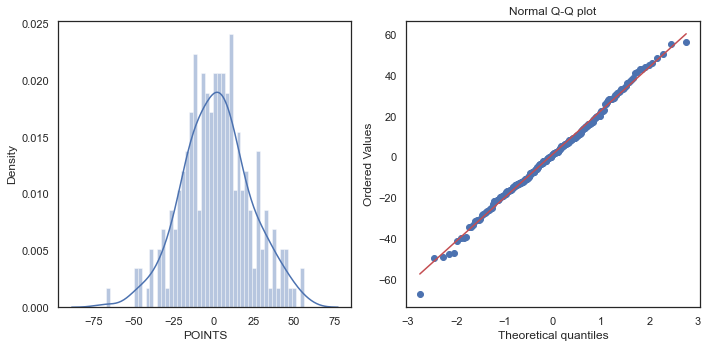

In [144]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)
train_set_pred = ridge_model.predict(X_tr)
    
sns.set_theme(style="white")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
# Train vs. Fitted
axes[0].scatter(y_train, train_set_pred, alpha=0.2)
axes[0].plot([0,110],[0,110])
axes[0].set_xlabel('Train Target')
axes[0].set_ylabel('Predicted Target')
axes[0].set_title("Train Target vs. Predicted Target")
    
# Test vs. Fitted
axes[1].scatter(y_test, test_set_pred)
axes[1].plot([0,110],[0,110])
axes[1].set_xlabel('Test Target')
axes[1].set_ylabel('Predicted Target')
axes[1].set_title("Test Target vs. Predicted Target")
    
# Plot Residuals vs. predicted
lin_reg_residuals = y_train - train_set_pred

axes[2].scatter(train_set_pred, lin_reg_residuals, alpha=0.2)
axes[2].plot([0,110], [0, 0])
axes[2].set_xlabel('Train Target')
axes[2].set_ylabel('Residual')
axes[2].set_title("Predictions vs. Residuals")

#fig.suptitle('Diagnostic Plots');
fig.tight_layout();

y_train_val_pred = lm_reg.predict(X_scaled)
y_test_pred  = lm_reg.predict(X_test_scaled) 
residual_test = y_test - y_test_pred

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
g1 = sns.distplot(residual_test, bins = 50, ax=axes[0])
stats.probplot(residual_test, dist="norm", plot=axes[1])
axes[1].set_title('Normal Q-Q plot')

fig.tight_layout();


# prediction on trainig model
RMSE = sqrt(mean_squared_error(y_train,train_set_pred))
MAE  = mean_absolute_error(y_train,train_set_pred)
# prediction on test model
RMSE1 = sqrt(mean_squared_error(y_test,test_set_pred))
MAE1   = mean_absolute_error(y_test,test_set_pred)

print(f'\nRIDGE Regularization (train set) R^2 : {r2_score(y_train, train_set_pred)}')
print(f'RIDGE Regularization (test set) R^2    : {r2_score(y_test, test_set_pred)}')
    
print(f'\nRoot Mean Square (RMSE) (train/val): {RMSE:.3f}')
print(f'Root Mean Square (RMSE) test         : {RMSE1:.3f}')
    
print(f'\nMean Absolute Error (MAE) (train/val): {MAE:.3f}')
print(f'Mean Absolute Error (MAE) test         : {MAE1:.3f}') # 5.870

In [154]:
# The MODEL from Feature engineering is
#
# y = -23.522 + 1.142X1 + 0.456X2 -1.235X3 +0.009X4 + 0.3X5 + 0.136X6 - 0.004X7 + 0.035X8 + 2.089X9 
# 

# The MODEL from CROSS VALIDATION (K-fold)
#
# y = 50.964893617021275 + 18.94558879X1 + 2.32026136X2 -2.54046315X3 +1.43877575X4 + 0.72357888X5 
#                        + 0.58594856X6 -6.97539076X7 + 1.84805248X8 + 1.01283977X9
#   GF : 18.94558879
#   POSSESSION_PERCENT : 2.32026136
#   SHOTS_PG : -2.54046315
#   TOTAL_MARKET_VALUE (m€) : 1.43877575
#   TACKLES_PG : 0.72357888
#   INTERCEPTIONS_PG : 0.58594856
#   GF2 : -6.97539076
#   SHOTS_PG2 : 1.84805248
#   TOTAL_MARKET_VALUE (m€)_LOG : 1.01283977

In [204]:

X3.head()

,GF,POSSESSION_PERCENT,SHOTS_PG,TOTAL_MARKET_VALUE (m€),TACKLES_PG,INTERCEPTIONS_PG,GF2,SHOTS_PG2,TOTAL_MARKET_VALUE (m€)_LOG
0,103,56.9,21.9,443.90,20.3,18.6,10609,479.61,2.647285
1,86,55.6,18.3,362.95,21.8,15.8,7396,334.89,2.559847
2,83,57.0,17.4,281.00,21.5,22.1,6889,302.76,2.448706
3,67,52.2,17.9,249.20,22.2,21.2,4489,320.41,2.396548
4,73,52.2,13.8,314.90,21.1,21.2,5329,190.44,2.498173


In [158]:
small_leagues_df['POINTS'].head()

0    86
1    85
2    75
3    70
4    67
Name: POINTS, dtype: int64

In [202]:
points_fe =  -23.523 + 1.142*X3['GF'][4] + 0.456*X3['POSSESSION_PERCENT'][4] \
             - 1.235*X3['SHOTS_PG'][4] + 0.009*X3['TOTAL_MARKET_VALUE (m€)'][4] \
             + 0.3*X3['TACKLES_PG'][4]  + 0.136*X3['INTERCEPTIONS_PG'][4] \
              - 0.004*X3['GF2'][4] + 0.0035*X3['SHOTS_PG2'][1] + 2.089*X3['TOTAL_MARKET_VALUE (m€)_LOG'][4]
print(f'Calculated Points (FE Model) ---> {points_fe}')

points    =  -16.535 + 0.7284*X3['GF'][4] + 0.5103*X3['POSSESSION_PERCENT'][4] \
             - 0.2471*X3['SHOTS_PG'][4] + 0.0099*X3['TOTAL_MARKET_VALUE (m€)'][4] \
             + 0.2629*X3['TACKLES_PG'][4]  + 0.1016*X3['INTERCEPTIONS_PG'][4]
print(f'Calculated Points (initial Model) ---> {points}')

Calculated Points (FE Model) ---> 63.72529768806973
Calculated Points (initial Model) ---> 70.6845


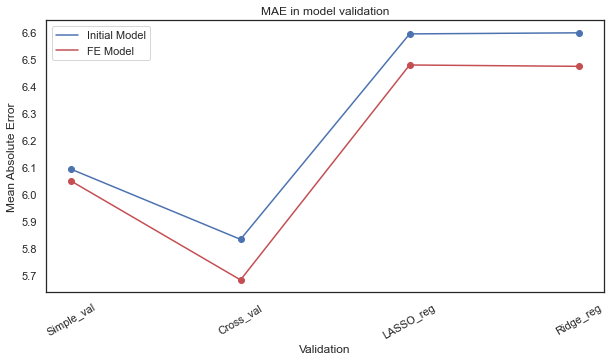

In [196]:
# Plot Mean Absolute Error of test set

validation = ['Simple_val','Cross_val', 'LASSO_reg', 'Ridge_reg']
target_err = [6.092, 5.833, 6.593, 6.597]
fe_target_err = [6.048, 5.683, 6.478, 6.473]

x_index = np.arange(len(validation))
ax.set_xticks(ticks=x_index)
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,5])
ax.plot(validation,target_err, 'bo')
ax.plot(validation,target_err, 'b-', label = 'Initial Model')
ax.plot(validation,fe_target_err, 'ro')
ax.plot(validation,fe_target_err, 'r-', label = 'FE Model')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
#ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.set_title('MAE in model validation')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel('Validation')
ax.set_xticklabels(validation,rotation = 30, horizontalalignment = 'center' )
ax.legend(loc='best');

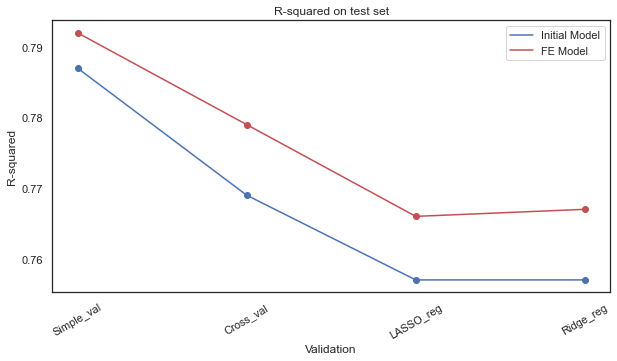

In [199]:
# Plot R^2 of test set

validation = ['Simple_val','Cross_val', 'LASSO_reg', 'Ridge_reg']
target_err = [6.092, 5.833, 6.593, 6.597]
fe_target_err = [6.048, 5.683, 6.478, 6.473]

target_r2 = [0.787, 0.769, 0.757, 0.757]
fe_target_r2 = [0.792, 0.779, 0.766, 0.767]

x_index = np.arange(len(validation))
ax.set_xticks(ticks=x_index)
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,5])
ax.plot(validation,target_r2, 'bo')
ax.plot(validation,target_r2, 'b-', label = 'Initial Model')
ax.plot(validation,fe_target_r2, 'ro')
ax.plot(validation,fe_target_r2, 'r-', label = 'FE Model')
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
#ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.set_title('R-squared on test set')
ax.set_ylabel('R-squared')
ax.set_xlabel('Validation')
ax.set_xticklabels(validation,rotation = 30, horizontalalignment = 'center' )
ax.legend(loc='best');